# Quantification SOLUTION



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tifffile
import skimage
import localthickness as lt

def lognormal_statistics(dist):
    log = np.log(dist)
    stats = {'mean': dist.mean(), 
             'median': np.exp(log.mean()), 
             'mode': np.exp(log.mean() - log.std()**2)
             }
    return stats


## Helping functions

In [2]:
def quantify(vol):

    # Binarization parameters
    smoothing_sigma = 0.5
    threshold = 80
    morphology_radius = 2

    # Binarization: gaussian smoothing, thresholding, morphology
    bin_vol = skimage.filters.gaussian(vol.astype(float)/255, sigma=smoothing_sigma)
    bin_vol = bin_vol > threshold/255
    bin_vol = skimage.morphology.binary_closing(bin_vol, skimage.morphology.ball(morphology_radius))

    # local thickness
    pore_th = lt.local_thickness(~bin_vol)
    pore_stats = lognormal_statistics(pore_th[~bin_vol])  # pore statistics
    mat_th = lt.local_thickness(bin_vol)
    mat_stats = lognormal_statistics(mat_th[bin_vol])  # material statistics
    
    # collecting statistics
    stats = {} 
    stats['material fraction'] = bin_vol.sum()/bin_vol.size
    for key in pore_stats.keys():
        stats['pore ' + key] = pore_stats[key]
    for key in mat_stats.keys():
        stats['material ' + key] = mat_stats[key]

    return stats

def blockwise_quantify(vol, s):
    
    X, Y, Z = vol.shape
    stats = []
    for x in range(0, X, s):
        for y in range(0, Y, s):
            for z in range(0, Z, s):
                print(f'\rProcessing block {x},{y},{z}', end=' '*20)
                subvol = vol[x:x+s, y:y+s, z:z+s]
                stats.append(quantify(subvol))
    print('\n')
    return stats


## Processing

In [3]:
vol2 = tifffile.imread('cement_data/cement2.tif')
vol3 = tifffile.imread('porosity_data/cement3.tif')

#vol2 = vol2[:300, :300, :300]
#vol3 = vol3[:300, :300, :300]

stats2 = blockwise_quantify(vol2, 100)
stats3 = blockwise_quantify(vol3, 100)


Processing block 700,700,700                    

Processing block 700,700,700                    



## Visualization

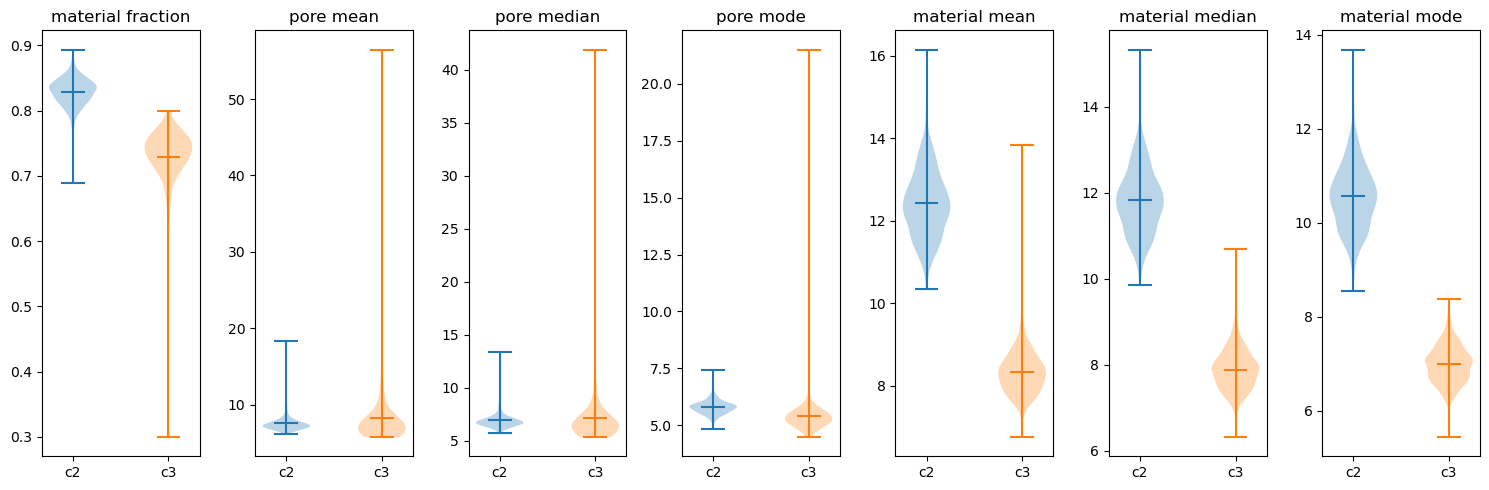

In [10]:
keys = stats2[0].keys()

fig, ax = plt.subplots(1, 7, figsize=(15, 5))
for key, a in zip(keys, ax):
    vals2 = [s[key] for s in stats2]
    vals3 = [s[key] for s in stats3]
    a.violinplot(vals2, positions=[1], showmeans=True)
    a.violinplot(vals3, positions=[2], showmeans=True)
    a.set_xticks([1, 2])
    a.set_xticklabels(['c2', 'c3'])
    a.set_title(key)
fig.tight_layout()
plt.show()

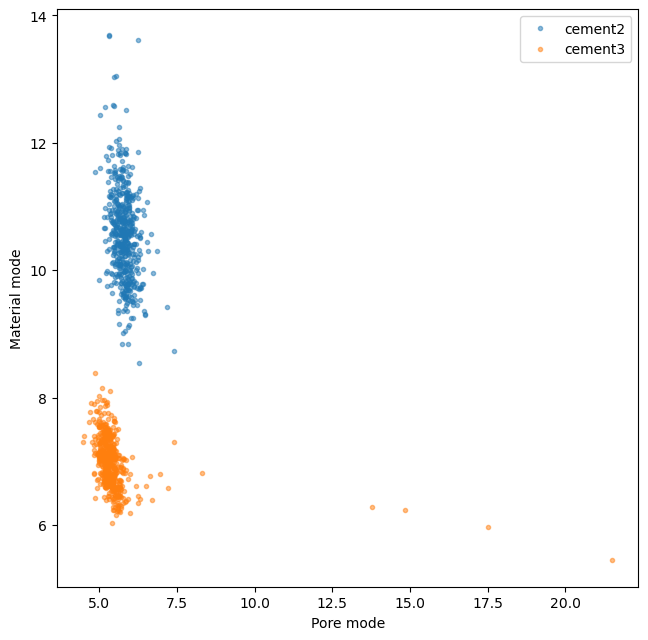

In [10]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
for stats in [stats2, stats3]:
    pore_mode = [s['pore mode'] for s in stats]
    material_mode = [s['material mode'] for s in stats]
    ax.plot(pore_mode, material_mode, '.', alpha=0.5)
ax.set_xlabel('Pore mode')
ax.set_ylabel('Material mode')
ax.legend(('cement2', 'cement3'))
plt.show()